# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 5)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

from tqdm import tqdm, tqdm_notebook
import quandl

In [3]:
from utils import *

In [56]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
# tickers, prices = get_quandl_sharadar(free=True)
tickers, prices = get_sharadar_train()
prices = prices.query('Set == "train"')

In [57]:
prices

Open    High    Low  Close      Volume  Dividends  \
Ticker Date                                                             
A      1999-11-18  45.50  50.000  40.00  44.00  44739900.0        0.0   
       1999-11-19  42.94  43.000  39.81  40.38  10897100.0        0.0   
...                  ...     ...    ...    ...         ...        ...   
ZYNE   2017-08-17   6.36   6.639   6.20   6.32    651837.0        0.0   
       2017-08-18   6.26   6.450   6.17   6.25    423696.0        0.0   

                   Closeunadj Lastupdated    Set  
Ticker Date                                       
A      1999-11-18       44.00  2018-02-11  train  
       1999-11-19       40.38  2018-02-11  train  
...                       ...         ...    ...  
ZYNE   2017-08-17        6.32  2017-11-01  train  
       2017-08-18        6.25  2017-11-01  train  

[14052292 rows x 9 columns]

# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

4912 days.


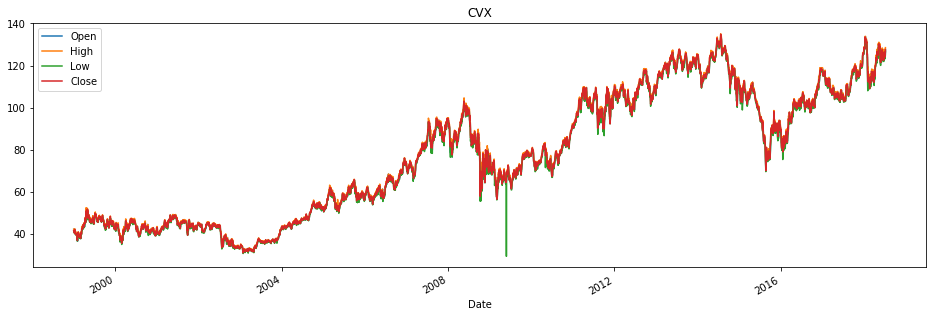

In [5]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [9]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [10]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [11]:
N_ga = 151
f_ga = gaussian(N_ga, std=20.)
f_ga = f_ga / f_ga.sum()

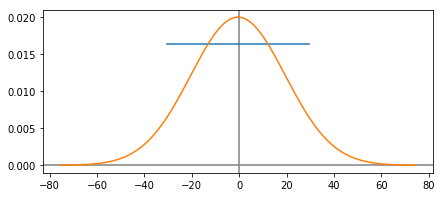

In [12]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Wiener 

In [13]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [14]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

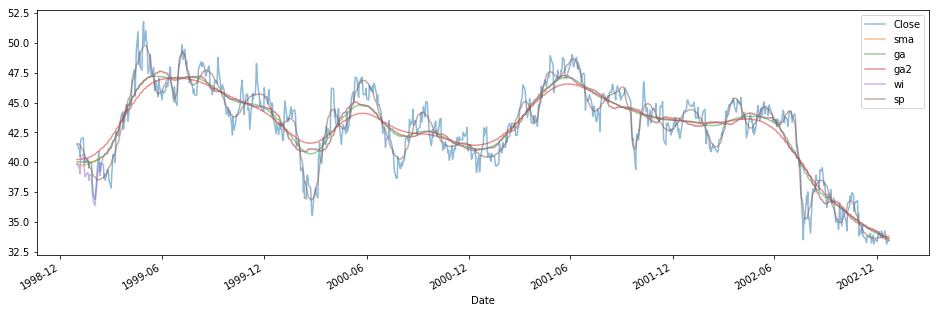

In [15]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

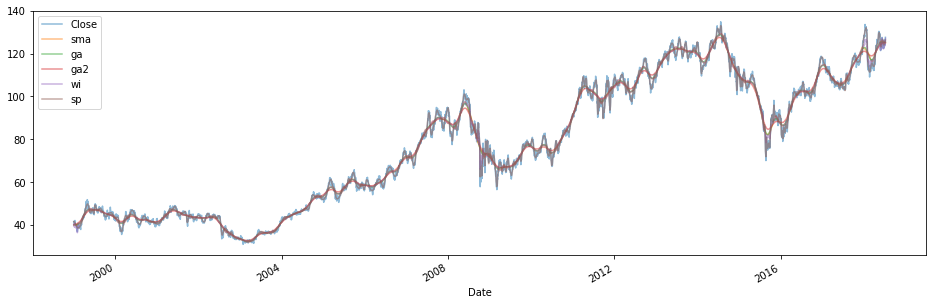

In [16]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [17]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [18]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [19]:
results = smooth_price(price)

In [20]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed
Date,,,,,,,,,
1998-12-31,42.155,42.22,41.405,41.47,1850200.0,0.0,82.94,2018-02-11,40.027394
1999-01-04,41.530,42.25,40.875,41.03,2937400.0,0.0,82.06,2018-02-11,40.026828
...,...,...,...,...,...,...,...,...,...
2018-07-09,125.000,126.28,124.690,125.99,3894945.0,0.0,125.99,2018-07-09,125.343435
2018-07-10,127.330,128.51,126.750,127.59,4914423.0,0.0,127.59,2018-07-10,125.342584


In [21]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [22]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [23]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [24]:
peaks

array([  95,  135,  352,  430,  604,  827, 1472, 1553, 1685, 1764, 1918,
       2015, 2206, 2366, 2500, 2617, 2752, 2843, 3092, 3310, 3452, 3664,
       3754, 3909, 4093, 4250, 4409, 4534, 4785, 4895])

In [25]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [26]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,
1998-12-31,42.155,42.22,41.405,41.47,1850200.0,0.0,82.94,2018-02-11,40.027394,-1.0,NaN
1999-01-04,41.530,42.25,40.875,41.03,2937400.0,0.0,82.06,2018-02-11,40.026828,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-09,125.000,126.28,124.690,125.99,3894945.0,0.0,125.99,2018-07-09,125.343435,-1.0,NaN
2018-07-10,127.330,128.51,126.750,127.59,4914423.0,0.0,127.59,2018-07-10,125.342584,-1.0,NaN


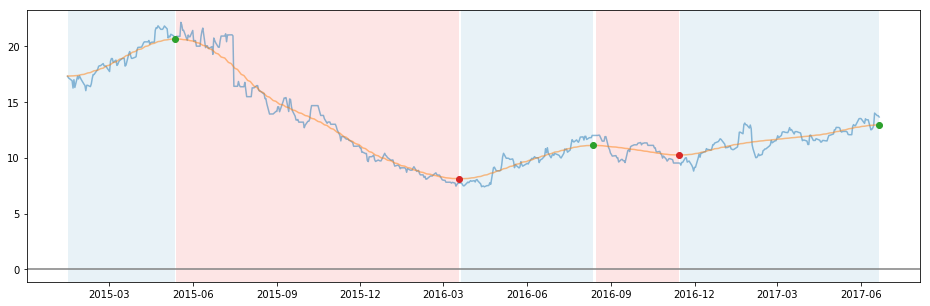

In [31]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [27]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

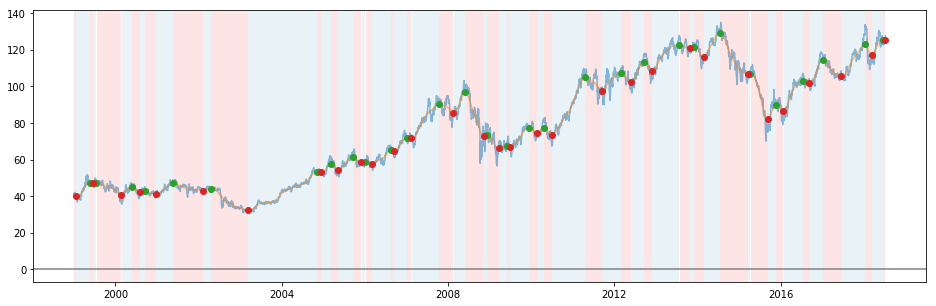

In [28]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [29]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.43831433, 0.        ],
       [0.        , 0.56168567]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [30]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [   0   12   96  117  136  289  353  403  431  499  605  781  828 1051
 1473 1495 1554 1599 1686 1741 1765 1803 1919 1938 2016 2042 2207 2295
 2367 2482 2501 2570 2618 2639 2753 2802 2844 2892 3093 3196 3311 3373
 3453 3501 3665 3727 3755 3810 3910 4078 4094 4200 4251 4294 4410 4451
 4535 4643 4786 4829 4896 4912]


In [31]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,
1999-05-20,45.875,47.155,45.875,46.875,2326000.0,0.0,93.75,2018-02-11,47.203306,-1.0,NaN,-1.0
1999-05-21,46.780,47.125,46.470,46.720,1933000.0,0.0,93.44,2018-02-11,47.200038,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1999-06-17,47.690,47.750,46.375,46.845,2711800.0,0.0,93.69,2018-02-11,47.082951,-1.0,NaN,-1.0
1999-06-18,46.875,47.405,46.470,46.595,3372000.0,0.0,93.19,2018-02-11,47.082171,-1.0,NaN,-1.0


In [32]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [33]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,
1998-12-31,42.155,42.22,41.405,41.47,1850200.0,0.0,82.94,2018-02-11,40.027394,-1.0,0.039517,-1.0
1999-01-04,41.530,42.25,40.875,41.03,2937400.0,0.0,82.06,2018-02-11,40.026828,-1.0,0.039517,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-09,125.000,126.28,124.690,125.99,3894945.0,0.0,125.99,2018-07-09,125.343435,-1.0,0.041082,-1.0
2018-07-10,127.330,128.51,126.750,127.59,4914423.0,0.0,127.59,2018-07-10,125.342584,-1.0,0.041082,-1.0


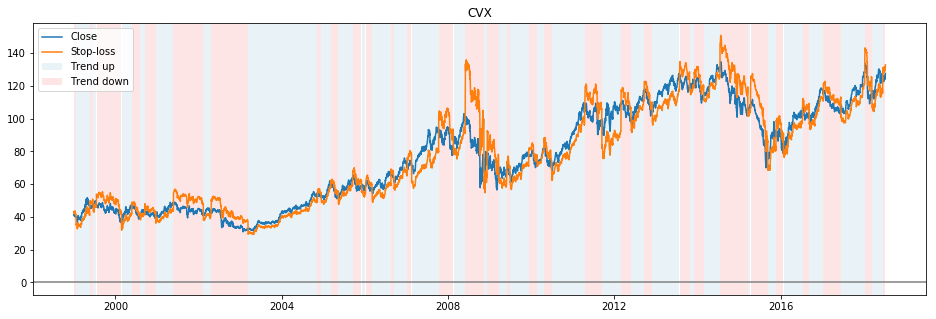

In [34]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

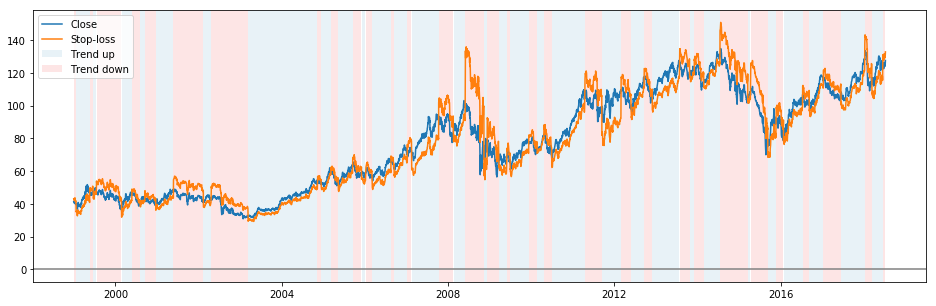

In [35]:
res2 = find_trends(price)
plot_trends(res2)

# Sample...

## A single asset 

In [70]:
from utils import *
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')

640 days.


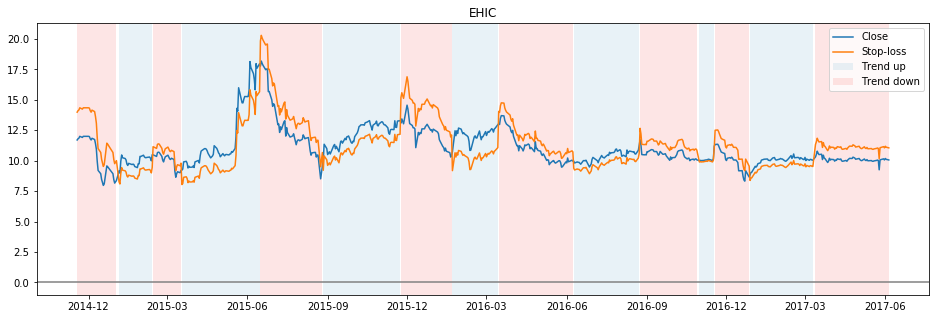

In [71]:
trends = find_trends(price, sd=10.)
plot_trends(trends, ticker)

In [72]:
DataFrame(trends.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,15.0,42.666667,15.809882,14.0,29.5,47.0,56.0,62.0


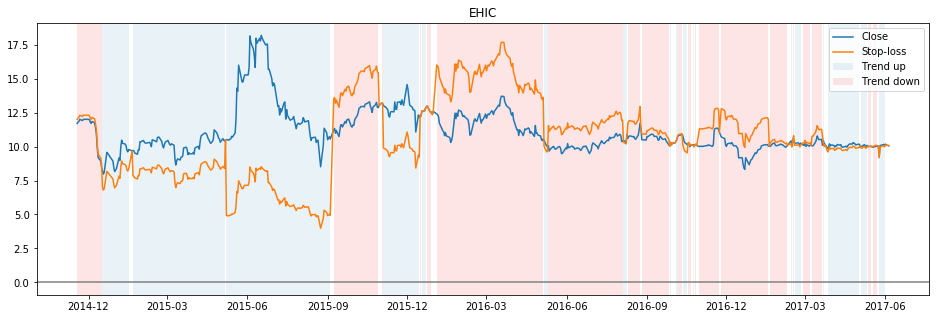

In [73]:
trends2 = find_trends(price, sd=100.)
plot_trends(trends2, ticker)

In [74]:
DataFrame(trends2.groupby('n_Trend').Trend.count().describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
Trend,60.0,10.666667,19.839754,1.0,1.0,2.0,7.5,86.0


In [77]:
def summarise_trends(df, sd=20.):
    trends = find_trends(df, sd)
    res = DataFrame(trends.groupby('n_Trend').Trend.count().describe())
    res = res.transpose().assign(sd = sd).set_index('sd')
    
    return res

In [79]:
sds = np.arange(5, 150, step=30)
sum_trends = pd.concat([summarise_trends(price, s) for s in sds], axis=0)

In [80]:
sum_trends

,count,mean,std,min,25%,50%,75%,max
sd,,,,,,,,
5,131.0,4.885496,3.800083,1.0,2.00,5.0,6.0,18.0
35,54.0,11.851852,16.307664,1.0,1.00,4.0,13.0,63.0
65,25.0,25.600000,27.670682,1.0,3.00,5.0,47.0,86.0
95,12.0,53.333333,26.112809,1.0,47.75,53.0,61.0,97.0
125,11.0,58.181818,22.080843,19.0,50.00,52.0,65.5,100.0


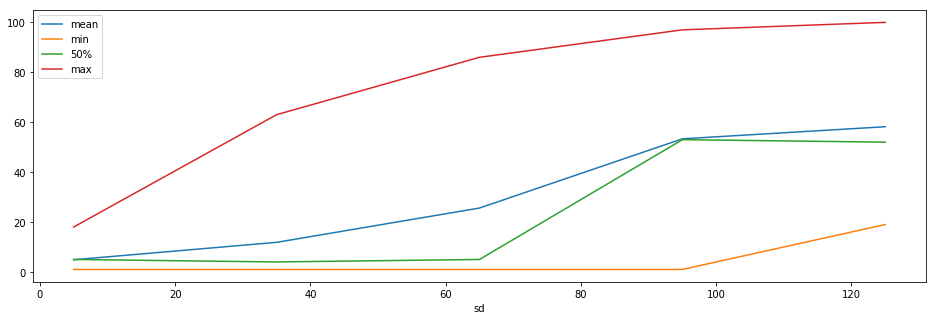

In [81]:
sum_trends[['mean', 'min', '50%', 'max']].plot()

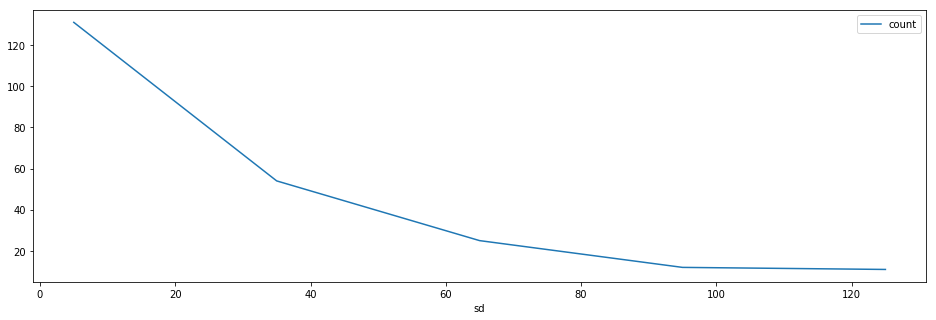

In [82]:
sum_trends[['count']].plot()

## Multiple assets

In [ ]:
sds = np.arange(5, 15, step=10)

results = []
grouped = prices.loc[np.random.choice(tickers, size=5)].groupby('Ticker')
for name, group in tqdm_notebook(grouped):
    sum_trends = pd.concat([summarise_trends(group, s) for s in sds], axis=0)
    sum_trends = sum_trends.assign(Ticker=name)
    results.append(sum_trends)

BKSC


In [86]:
results = pd.concat(results, axis=0)
results

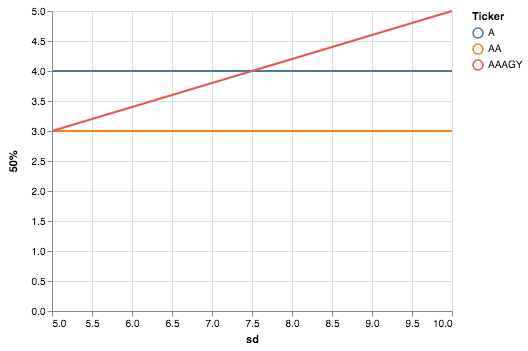

In [94]:
import altair as alt
alt.renderers.enable('notebook')
alt.Chart(results.reset_index()).mark_line().encode(
    x='sd',
    y='50%',
    color='Ticker'
).properties(
    width=1200,
    height=400
).interactive()


# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).